# Santander Customer Transaction Prediction

This notebook presents testing different feature engineering techniques and models to solve given classification problem


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from copy import deepcopy

In [5]:
from scipy.stats import norm

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
df = pd.read_csv('train.csv')

In [17]:
df['sum'] = df.drop(['ID_code', 'target'], axis=1).sum(axis=1)
df['mean'] = df.drop(['ID_code', 'target'], axis=1).mean(axis=1)
df['std'] = df.drop(['ID_code', 'target'], axis=1).std(axis=1)

In [48]:
df['sum'].mean()

4080.6706517004027

In [47]:
df['sum'].std()

242.12693279386514

In [49]:
df['sqrt_diff_to_std'] = df['sqrt_diff_sum_mean']/df['sum'].std()

In [28]:
df['sqrt_diff_sum_mean'] = np.sqrt(np.power(df['sum']-df['sum'].mean(), 2))

In [51]:
df['sqrt_diff_mean_mean'] = np.sqrt(np.power(df['mean']-df['mean'].mean(), 2))

In [54]:
df['sqrt_diff_81_mean'] = np.sqrt(np.power(df['var_81']-df['var_81'].mean(), 2))

In [58]:
df['sqrt_diff_12_mean'] = np.sqrt(np.power(df['var_12']-df['var_12'].mean(), 2))

In [62]:
df['sqrt_diff_139_mean'] = np.sqrt(np.power(df['var_139']-df['var_139'].mean(), 2))

In [67]:
df['sqrt_diff_6_mean'] = np.sqrt(np.power(df['var_6']-df['var_6'].mean(), 2))

In [69]:
df['sqrt_diff_53_mean'] = np.sqrt(np.power(df['var_53']-df['var_53'].mean(), 2))

In [189]:
df['81_139'] = df['var_81']df['var_139']

In [594]:
df['81_12_mean'] = df[['var_81', 'var_12']].mean(axis=1)

In [213]:
df['139_12_mean'] = df[['var_139', 'var_12']].mean(axis=1)

In [595]:
df['6_53_mean'] = df[['var_6', 'var_53']].mean(axis=1)

In [600]:
df['6_53_81_12_mean'] = df[['81_12_mean', '6_53_mean']].sum(axis=1)

In [8]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [33]:
df_copy = deepcopy(df)

In [34]:
df_copy.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [11]:
to_drop = ['target', 'ID_code']
extra_features = []
for column in df.drop(['target', 'ID_code'], axis=1):
    to_drop.append(column)
    for col in df.drop(to_drop, axis=1):
        corr = df['target'].corr(df[[column, col]].mean(axis=1))
        if  corr >= 0.09 or corr <= -0.09:
            print('Columns {} and {} correlation to target: {}'.format(column, col, corr))
            extra_features.append([column, col])

Columns var_6 and var_53 correlation to target: 0.09185173037823574
Columns var_9 and var_81 correlation to target: -0.0914989341196716
Columns var_13 and var_139 correlation to target: -0.09174558669805581
Columns var_21 and var_139 correlation to target: -0.09323382219232525
Columns var_34 and var_81 correlation to target: -0.09082014109909041
Columns var_76 and var_139 correlation to target: -0.09575331304963206
Columns var_80 and var_139 correlation to target: -0.0931516593179074
Columns var_81 and var_115 correlation to target: -0.09080278240079542
Columns var_81 and var_139 correlation to target: -0.09402083092609857
Columns var_81 and var_146 correlation to target: -0.10125411355748727
Columns var_81 and var_192 correlation to target: -0.09106515820158542
Columns var_81 and var_198 correlation to target: -0.09099500933517532
Columns var_139 and var_146 correlation to target: -0.09008210349620382
Columns var_139 and var_165 correlation to target: -0.09231370124613145
Columns var_

In [27]:
to_drop = ['target', 'ID_code']
extra_features_norm = []
for column in df.drop(['target', 'ID_code'], axis=1):
    to_drop.append(column)
    for col in df.drop(to_drop, axis=1):
        corr = df['target'].corr(np.sqrt(df[column]**2+df[col]**2))
        if  corr >= 0.075 or corr <= -0.075:
            print('Columns {} and {} correlation to target: {}'.format(column, col, corr))
            extra_features_norm.append([column, col])

Columns var_0 and var_2 correlation to target: 0.07865307360421396
Columns var_0 and var_22 correlation to target: 0.07539573264874769
Columns var_0 and var_110 correlation to target: 0.08578578903952568
Columns var_0 and var_190 correlation to target: 0.07727381838666038
Columns var_1 and var_81 correlation to target: -0.07708399441967555
Columns var_2 and var_22 correlation to target: 0.08059373207624038
Columns var_2 and var_110 correlation to target: 0.09059192729665774
Columns var_2 and var_190 correlation to target: 0.08162242177723762
Columns var_2 and var_191 correlation to target: 0.07584588664458715
Columns var_6 and var_22 correlation to target: 0.08762940242342569
Columns var_6 and var_53 correlation to target: 0.09393635101858464
Columns var_6 and var_91 correlation to target: 0.07597335752192921
Columns var_6 and var_110 correlation to target: 0.08674536497188494
Columns var_6 and var_133 correlation to target: 0.0863629661591695
Columns var_6 and var_179 correlation to t

Columns var_133 and var_179 correlation to target: 0.0752798471008056
Columns var_148 and var_166 correlation to target: -0.07696609396675529
Columns var_165 and var_174 correlation to target: -0.07594919520200795
Columns var_179 and var_190 correlation to target: 0.08078893899512937
Columns var_190 and var_191 correlation to target: 0.07603055817902121


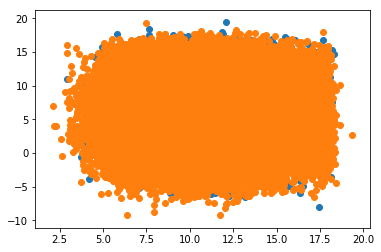

In [54]:
plt.scatter(df[df['target']==1]['var_2'], df[df['target']==1]['var_110'])
plt.scatter(df[df['target']==0]['var_2'], df[df['target']==0]['var_110'])

In [31]:
to_drop = ['target', 'ID_code']
extra_features_scale = []
for column in df.drop(['target', 'ID_code'], axis=1):
    corr = df['target'].corr(np.round(df[column]*100))
    if  corr >= 0.05 or corr <= -0.05:
        print('Column {} correlation to target: {}'.format(column, corr))
        extra_features_scale.append(column)

Column var_0 correlation to target: 0.05239223482362444
Column var_1 correlation to target: 0.05034127859921031
Column var_2 correlation to target: 0.05587103444453486
Column var_6 correlation to target: 0.06673697074313974
Column var_12 correlation to target: -0.0695123537856448
Column var_13 correlation to target: -0.05515497374574967
Column var_21 correlation to target: -0.058482171573469015
Column var_22 correlation to target: 0.06055833086743066
Column var_26 correlation to target: 0.06242209068708456
Column var_34 correlation to target: -0.05269746566018739
Column var_53 correlation to target: 0.06339756253438962
Column var_76 correlation to target: -0.061917172945558895
Column var_80 correlation to target: -0.05760982086806949
Column var_81 correlation to target: -0.0809158611098604
Column var_99 correlation to target: 0.058368371322581616
Column var_110 correlation to target: 0.0642757930387936
Column var_115 correlation to target: -0.05017307204496359
Column var_133 correlatio

In [32]:
to_drop = ['target', 'ID_code']
extra_features_binning = []
for column in df.drop(['target', 'ID_code'], axis=1):
    corr = df['target'].corr(pd.qcut(
        df[column],
        [0, 0.25, 0.5, 0.75, 1], labels=False))
    if  corr >= 0.05 or corr <= -0.05:
        print('Column {} correlation to target: {}'.format(column, corr))
        extra_features_binning.append(column)

Column var_6 correlation to target: 0.05655765809478778
Column var_12 correlation to target: -0.05576132655838171
Column var_21 correlation to target: -0.052445068284976776
Column var_53 correlation to target: 0.05148277247306724
Column var_76 correlation to target: -0.053486508559727884
Column var_81 correlation to target: -0.063259706581788
Column var_110 correlation to target: 0.053700948504553925
Column var_139 correlation to target: -0.06406568124078854
Column var_146 correlation to target: -0.05352963796579191
Column var_174 correlation to target: -0.05016306536540415


In [35]:
for x, y in extra_features:
    df_copy['{}_{}_mean'.format(x,y)] = df[[x, y]].mean(axis=1)

for x, y in extra_features_norm:
    df_copy['{}_{}_norm'.format(x,y)] = np.sqrt(df[x]**2+df[y]**2)

for x in extra_features_scale:
    df_copy['{}_scale'.format(x)] = np.round(df[column]*100)

for x in extra_features_binning:
    df_copy['{}_binning'.format(x)] = pd.qcut(df[column], [0, 0.25, 0.5, 0.75, 1], labels=False)

In [36]:
df_copy.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_6_binning,var_12_binning,var_21_binning,var_53_binning,var_76_binning,var_81_binning,var_110_binning,var_139_binning,var_146_binning,var_174_binning
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,2,2,2,2,2,2,2,2,2,2
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,2,2,2,2,2,2,2,2,2,2
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2,2,2,2,2,2,2,2,2,2
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,1,1,1,1,1,1,1,1,1,1
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,1,1,1,1,1,1,1,1,1,1


In [559]:
for column in df.drop(['target', 'ID_code'], axis=1):
    print('COLUMN NAME:', column)
    print('1> mean:', df[df['target']==1][column].mean())
    print('1> std:', df[df['target']==1][column].std())
    print('0> mean:', df[df['target']==0][column].mean())
    print('0> std:', df[df['target']==0][column].std())

COLUMN NAME: var_0
1> mean: 11.15641803662056
1> std: 3.27029310122627
0> mean: 10.62668097464175
0> std: 3.0085635212977366
COLUMN NAME: var_1
1> mean: -1.0176128321225992
1> std: 4.220637674232161
0> mean: -1.6957696701537506
0> std: 4.024812721033275
COLUMN NAME: var_2
1> mean: 11.156633053040103
1> std: 2.8410753666142945
0> mean: 10.66587563840313
0> std: 2.6129614947393676
COLUMN NAME: var_3
1> mean: 6.864113205294059
1> std: 2.07089814647975
0> mean: 6.788978911852008
0> std: 2.040081619820193
COLUMN NAME: var_4
1> mean: 11.131337207682357
1> std: 1.6492658551260058
0> mean: 11.072411829218133
0> std: 1.6201027392269083
COLUMN NAME: var_5
1> mean: -4.336522022091751
1> std: 8.140280783879799
0> mean: -5.146735884537136
0> std: 7.827521949174259
COLUMN NAME: var_6
1> mean: 5.581965946860384
1> std: 0.922441994707387
0> mean: 5.389619819123745
0> std: 0.8579833911188655
COLUMN NAME: var_7
1> mean: 16.514917021594187
1> std: 3.421365009442334
0> mean: 16.549305597491966
0> std: 3.4

1> mean: 6.307786725047269
1> std: 1.500046298372552
0> mean: 6.376013423975276
0> std: 1.4841064519320615
COLUMN NAME: var_65
1> mean: 1.1099330530401035
1> std: 3.7954653157140195
0> mean: 0.9686988582672789
0> std: 3.785235625035758
COLUMN NAME: var_66
1> mean: 5.871586575778685
1> std: 1.143637144178091
0> mean: 5.785375552800969
0> std: 1.1185193327020273
COLUMN NAME: var_67
1> mean: 12.92761701661857
1> std: 7.596216219040759
0> mean: 11.83325048859935
0> std: 7.33066307597873
COLUMN NAME: var_68
1> mean: 5.018636366802666
1> std: 0.007351440108414734
0> mean: 5.018922177074186
0> std: 0.007167027274587526
COLUMN NAME: var_69
1> mean: -3.233486834510896
1> std: 4.058562825837633
0> mean: -3.3424664478438255
0> std: 3.9439275592872614
COLUMN NAME: var_70
1> mean: 25.403251353368496
1> std: 12.053624047407224
0> mean: 24.339961003768718
0> std: 11.935580994552167
COLUMN NAME: var_71
1> mean: 0.6965710667728132
1> std: 0.2714859454175373
0> mean: 0.6667601988860601
0> std: 0.2659886

1> mean: -0.8672644292964474
1> std: 3.2884107080215155
0> mean: -1.157075123122589
0> std: 3.2310705003874274
COLUMN NAME: var_129
1> mean: 15.387547840581153
1> std: 4.159781990330172
0> mean: 15.468443555936013
0> std: 4.133770138724069
COLUMN NAME: var_130
1> mean: 12.331639605930938
1> std: 0.8631594499147852
0> mean: 12.248829278718413
0> std: 0.8282550253745286
COLUMN NAME: var_131
1> mean: 0.5004703701860882
1> std: 0.4678281336713285
0> mean: 0.5496117552889906
0> std: 0.45470653947370204
COLUMN NAME: var_132
1> mean: 7.692869887551
1> std: 1.5012057677844286
0> mean: 7.811607900968305
0> std: 1.4509208422425406
COLUMN NAME: var_133
1> mean: 6.874568409792019
1> std: 0.40143190461715017
0> mean: 6.806422478349325
0> std: 0.3719813198841945
COLUMN NAME: var_134
1> mean: -4.508510214946762
1> std: 6.296971654559417
0> mean: -4.861527225378262
0> std: 6.150335283229227
COLUMN NAME: var_135
1> mean: -3.6225904965668225
1> std: 7.907069872457169
0> mean: -4.330622277128659
0> std: 

COLUMN NAME: var_192
1> mean: 1.7382661110558266
1> std: 1.4825372455855375
0> mean: 1.9490168563995953
0> std: 1.4764559270427096
COLUMN NAME: var_193
1> mean: 3.120260468703354
1> std: 4.067549946732636
0> mean: 3.3554031750619786
0> std: 3.9828187075687467
COLUMN NAME: var_194
1> mean: 17.779568061498658
1> std: 3.19315296394307
0> mean: 18.01771563239986
0> std: 3.1277147723680505
COLUMN NAME: var_195
1> mean: -0.021130316449397946
1> std: 1.4859746818213597
0> mean: -0.15560143633756154
0> std: 1.4222747576317516
COLUMN NAME: var_196
1> mean: 2.6885834063090854
1> std: 5.556891891851311
0> mean: 2.260296713766384
0> std: 5.441117983230629
COLUMN NAME: var_197
1> mean: 8.810814991541447
1> std: 0.9525536877831727
0> mean: 8.919032456559682
0> std: 0.9174671956696993
COLUMN NAME: var_198
1> mean: 15.393282983381432
1> std: 3.2481228637714685
0> mean: 15.924057810363422
0> std: 2.9785392507569903
COLUMN NAME: var_199
1> mean: -2.532242805254254
1> std: 10.435910279580382
0> mean: -3.

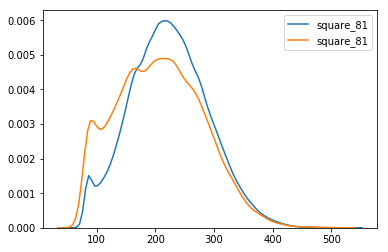

In [543]:
sns.kdeplot(df[df['target']==0]['square_81'])
sns.kdeplot(df[df['target']==1]['square_81'])

In [486]:
df_best = df[['ID_code', 'target', 'var_6', 'var_12', 'var_53', 'var_81', 'var_139']]
df_best.head()

,ID_code,target,var_6,var_12,var_53,var_81,var_139
0,train_0,0,5.1187,14.0137,5.1736,13.8372,15.6599
1,train_1,0,5.6208,14.0239,6.6885,18.1782,16.1622
2,train_2,0,6.9427,14.1929,6.4059,15.7811,8.6674
3,train_3,0,5.8428,13.8463,5.2091,10.5404,8.9821
4,train_4,0,5.9405,13.8481,5.7555,13.3317,13.9547


In [619]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,81_12_mean,6_53_mean
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,13.92545,5.14615
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,16.10105,6.15465
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,14.98700,6.67430
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,12.19335,5.52595
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,13.58990,5.84800


In [178]:
df['var_139'].head()

0    15.6599
1    16.1622
2     8.6674
3     8.9821
4    13.9547
Name: var_139, dtype: float64

In [618]:
df = df.drop(['6_53_81_12_mean'], axis=1)

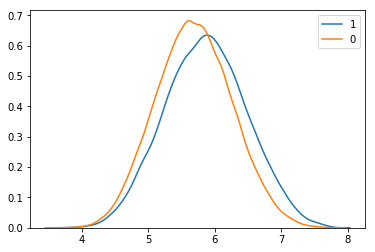

In [485]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(df[df['target']==1]['6_53_mean'], ax=ax)
sns.kdeplot(df[df['target']==0]['6_53_mean'], ax=ax)
ax.legend(['1','0'])

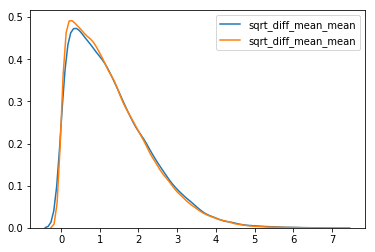

In [80]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_mean_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_mean_mean'])

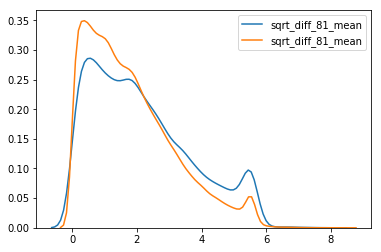

In [66]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_81_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_81_mean'])

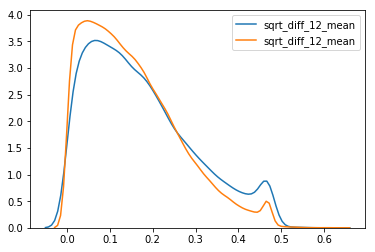

In [65]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_12_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_12_mean'])

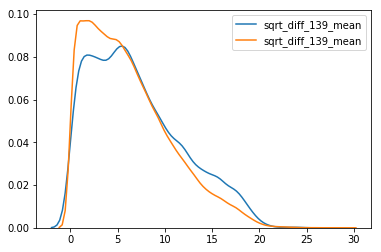

In [64]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_139_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_139_mean'])

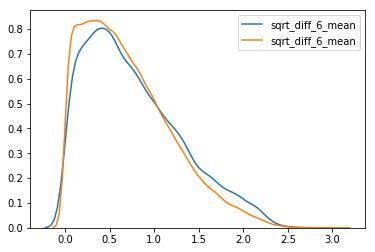

In [68]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_6_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_6_mean'])

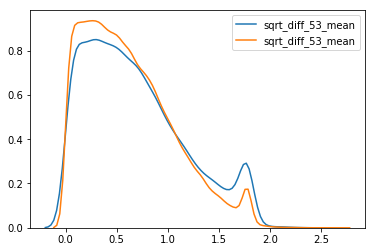

In [70]:
sns.kdeplot(df[df['target']==1]['sqrt_diff_53_mean'])
sns.kdeplot(df[df['target']==0]['sqrt_diff_53_mean'])

In [604]:
corr_matrix = df.corr()

In [615]:
corr_matrix['target'].to_list()[202]

0.09185173037815611

In [624]:
corr_matrix['target'].to_list().index(0.06427529889094545)

111

In [622]:
sorted(corr_matrix['target'].to_list())

[-0.0863211662344288,
 -0.08091733227447406,
 -0.07407963274153047,
 -0.06948928249631348,
 -0.06364388347717469,
 -0.06191746591383834,
 -0.06166906759398399,
 -0.058482738148865926,
 -0.057773032604770104,
 -0.05760948113815606,
 -0.05573378752784447,
 -0.055156277483636953,
 -0.0550110905265359,
 -0.052999641368534606,
 -0.052692106739617925,
 -0.05017423722093442,
 -0.04992600004585765,
 -0.04903938961065858,
 -0.048382176132145925,
 -0.04731907892015406,
 -0.046295264840697986,
 -0.046106039917207416,
 -0.044791155673611485,
 -0.044333933503688645,
 -0.042858399358764766,
 -0.04280549959658876,
 -0.04246106143446736,
 -0.040291336363078994,
 -0.039996975075398414,
 -0.03978828553882732,
 -0.039126240043722546,
 -0.03912487913295286,
 -0.038396588483848575,
 -0.038081129743113125,
 -0.03797646858284018,
 -0.03686307263200648,
 -0.03610912625725373,
 -0.03586019723696796,
 -0.0353027378683705,
 -0.03506998945384066,
 -0.034999506770033315,
 -0.034014582795195446,
 -0.032380325973412

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_id, valid_id in split.split(df, df['target']):
    df_train = df.loc[train_id]
    df_valid = df.loc[valid_id]

In [37]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_id, valid_id in split.split(df_copy, df_copy['target']):
    df_train = df_copy.loc[train_id]
    df_valid = df_copy.loc[valid_id]

In [38]:
df_train.shape

(160000, 378)

In [42]:
X_train.shape

(160000, 376)

In [40]:
X_train = df_train.drop(['ID_code', 'target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['ID_code', 'target'], axis=1)
y_valid = df_valid['target']

In [685]:
X = df.drop(['ID_code', 'target'], axis=1)
y = df['target']

In [41]:
X.head()

NameError: name 'X' is not defined

In [41]:
X_train = df_train_wo.drop(['ID_code', 'target'], axis=1)
y_train = df_train_wo['target']

X_valid = df_valid.drop(['ID_code', 'target'], axis=1)
y_valid = df_valid['target']

In [36]:
def drop_outliers(frame, column):
    Q1 = frame[column].quantile(0.25)
    Q3 = frame[column].quantile(0.75)
    IQR = Q3 - Q1
    return frame[
        (frame[column] > Q1-1.5*IQR) & (frame[column] < Q3+1.5*IQR)
    ]

def drop_outliers_all(frame):
    new_frame = frame
    for column in frame:
        new_frame = drop_outliers(new_frame, column)
    return new_frame

In [38]:
df_train_wo = drop_outliers_all(df_train.drop(['ID_code', 'target'], axis=1))
df_train_wo.shape

(140021, 200)

In [39]:
df_train_wo = pd.concat([df_train_wo, df_train[['ID_code', 'target']]], axis=1)

In [40]:
df_train_wo = df_train_wo.dropna(axis=0)
df_train_wo.shape

(140021, 202)

In [35]:
df_train.target.value_counts()/df_train.shape[0]

0    0.899513
1    0.100487
Name: target, dtype: float64

In [32]:
df_valid.target.value_counts()/df_valid.shape[0]

0    0.902325
1    0.097675
Name: target, dtype: float64

In [287]:
df_test = pd.read_csv('test.csv')

In [288]:
X_test = df_test.drop(['ID_code'], axis=1)

In [5]:
df.shape

(200000, 202)

In [8]:
df_test.shape

(200000, 201)

In [7]:
df.info

<bound method DataFrame.info of              ID_code  target    var_0   var_1    var_2    var_3    var_4  \
0            train_0       0   8.9255 -6.7863  11.9081   5.0930  11.4607   
1            train_1       0  11.5006 -4.1473  13.8588   5.3890  12.3622   
2            train_2       0   8.6093 -2.7457  12.0805   7.8928  10.5825   
3            train_3       0  11.0604 -2.1518   8.9522   7.1957  12.5846   
4            train_4       0   9.8369 -1.4834  12.8746   6.6375  12.2772   
5            train_5       0  11.4763 -2.3182  12.6080   8.6264  10.9621   
6            train_6       0  11.8091 -0.0832   9.3494   4.2916  11.1355   
7            train_7       0  13.5580 -7.9881  13.8776   7.5985   8.6543   
8            train_8       0  16.1071  2.4426  13.9307   5.6327   8.8014   
9            train_9       0  12.5088  1.9743   8.8960   5.4508  13.6043   
10          train_10       0   5.0702 -0.5447   9.5900   4.2987  12.3910   
11          train_11       0  12.7188 -7.9750  10.3757  

In [11]:
df.corr()['target'].sort_values(ascending=False)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
var_1      0.050343
var_179    0.050002
var_40     0.049530
var_184    0.048315
var_78     0.048245
var_170    0.047973
var_191    0.047114
var_94     0.046296
var_67     0.044673
var_18     0.043479
var_173    0.042022
var_164    0.040997
var_118    0.040358
var_147    0.040280
var_91     0.040127
var_89     0.039369
var_95     0.038531
var_155    0.037240
var_35     0.036567
             ...   
var_86    -0.039126
var_121   -0.039788
var_107   -0.039997
var_123   -0.040291
var_122   -0.042461
var_9     -0.042805
var_192   -0.042858
var_33    -0.044334
var_108   -0.044791
var_154   -0.046106
var_92    -0.046295
var_149   -0.047319
var_169   -0.048382
var_44    -0.049039
var_109   -0.049926
var_115   -0.050174
var_34    -0.052692
var_198   -0.053000
var_148   -0.055011


(array([2.0000e+00, 6.0000e+00, 4.0000e+00, 1.8000e+01, 1.0570e+03,
        3.3160e+03, 1.4560e+03, 1.5540e+03, 1.7690e+03, 2.0010e+03,
        2.3520e+03, 2.7830e+03, 3.4420e+03, 3.9920e+03, 5.0100e+03,
        5.8490e+03, 7.0390e+03, 7.6510e+03, 7.6350e+03, 8.9320e+03,
        9.3740e+03, 1.0314e+04, 1.0690e+04, 1.0931e+04, 1.0824e+04,
        1.0657e+04, 1.0338e+04, 9.6220e+03, 8.9980e+03, 8.2150e+03,
        7.0310e+03, 6.1740e+03, 5.1960e+03, 4.2030e+03, 3.2840e+03,
        2.5340e+03, 1.8210e+03, 1.3500e+03, 9.4100e+02, 6.2600e+02,
        4.4100e+02, 2.5700e+02, 1.3300e+02, 7.3000e+01, 5.2000e+01,
        2.6000e+01, 1.4000e+01, 6.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([ 7.5865  ,  7.897418,  8.208336,  8.519254,  8.830172,  9.14109 ,
         9.452008,  9.762926, 10.073844, 10.384762, 10.69568 , 11.006598,
        11.317516, 11.628434, 11.939352, 12.25027 , 12.561188, 12.872106,
        13.183024, 13.493942, 13.80486 , 14.115778, 14.426696, 14.737614,
        15.048532, 15.

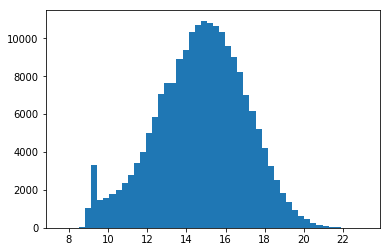

In [14]:
plt.hist(df['var_81'], bins=50)

(array([179902.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  20098.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

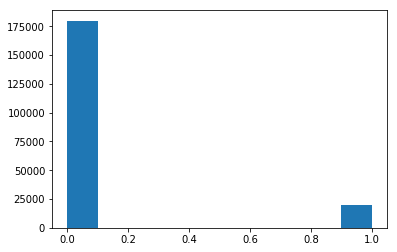

In [15]:
plt.hist(df['target'])

In [6]:
X = df.drop(['ID_code', 'target'], axis=1)
y = df['target']

In [8]:
df.target.value_counts() / df.shape[0]

0    0.89951
1    0.10049
Name: target, dtype: float64

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_id, valid_id in split.split(df, df['target']):
    df_train = df.loc[train_id]
    df_valid = df.loc[valid_id]

In [8]:
df_train.target.value_counts() / df_train.shape[0]

0    0.899513
1    0.100487
Name: target, dtype: float64

In [9]:
df_valid.target.value_counts() / df_valid.shape[0]

0    0.8995
1    0.1005
Name: target, dtype: float64

In [38]:
df_train.shape

(160000, 202)

In [12]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
172692,train_172692,0,15.4140,-2.1016,10.4773,4.8941,12.6506,-3.7205,5.1426,17.7048,4.2444,8.6555,10.0209,-13.4563,14.0022,13.0615,11.3380,14.6171,4.2687,-5.6576,21.0008,6.9801,8.9196,28.8931,-0.3950,2.4799,9.3506,13.6931,1.2336,-0.9651,5.6141,5.0811,-18.5176,9.5308,1.0793,23.3622,11.2098,-5.4244,1.9605,1.4301,...,39.1655,5.6497,6.0794,6.8441,1.6970,13.9070,3.4186,-17.0075,6.9393,5.5012,-10.0089,-4.1131,19.3432,2.6488,17.6551,13.4570,-14.8274,9.3351,11.6851,0.2308,-5.7969,10.6242,4.4049,10.5102,13.5850,1.6301,3.3935,6.7777,20.3512,0.8541,-2.8810,8.1647,1.0927,2.1215,17.6536,3.2253,-2.1234,8.9516,13.3485,-16.0178
123366,train_123366,0,12.3576,-8.1666,11.7785,2.8869,12.3183,-6.9847,4.2671,9.6710,3.0662,4.8252,4.8508,10.5200,14.0069,3.4091,9.6423,13.9715,8.6455,-4.3503,11.3110,7.3729,6.3876,11.2888,-0.8828,3.4036,8.1691,13.6494,-4.4422,0.8522,6.1120,3.2191,-25.5764,13.5301,1.9318,18.3917,11.0016,8.0777,5.6636,8.9416,...,2.3375,5.7364,4.7086,14.3870,-2.0900,20.0077,2.9240,-4.7379,6.9730,6.0900,-4.8115,-4.2070,21.4175,-0.3673,31.9218,6.2423,2.0323,10.5502,-3.9359,3.8987,1.5626,12.2243,0.9202,7.5942,7.6201,-7.7566,4.7447,15.2018,14.6897,0.7217,0.2397,8.1569,-1.0753,5.4679,23.6376,-0.5022,9.2414,8.2427,10.7546,-3.4394
6709,train_6709,0,9.4142,-8.6132,7.2196,3.2496,10.6550,-3.3245,5.1010,18.5389,1.8721,9.5959,2.5557,-19.6587,14.3897,5.0833,5.8540,13.8351,7.2027,-4.5545,15.3092,19.0314,21.6955,32.0834,2.0789,3.1161,10.1344,13.9411,-3.8679,-0.5708,6.4257,0.7172,-10.7685,7.1836,0.3945,16.8992,10.6346,11.4058,5.2833,7.1661,...,13.7295,5.6755,7.8791,15.1591,-7.9730,23.7192,2.3378,-4.0857,9.7302,5.6965,-1.9245,5.0487,40.0942,-5.2303,22.2878,18.5411,0.1946,7.8347,-15.2560,4.7384,-0.2029,12.7439,-11.9459,9.7034,7.8944,-4.3400,9.9037,-14.7085,17.9592,1.6213,8.1638,9.2399,1.0160,7.4548,17.0933,0.0715,-4.0455,9.4586,17.8789,-13.9784
30154,train_30154,0,13.0647,-0.7917,13.0270,8.7865,10.2252,-2.9311,6.7299,11.8682,-2.1274,8.6047,6.3384,-8.8210,13.8234,7.4468,7.7915,14.2038,11.5899,1.7521,24.8569,20.7430,8.8049,21.4416,7.4205,3.7158,17.3274,13.1772,-18.5741,-3.9581,5.6960,2.5710,-13.4870,9.4191,2.2091,20.8601,11.1699,-4.2843,5.6461,5.1334,...,41.0334,5.4016,3.9328,6.6076,-5.5778,13.4939,2.5813,3.6267,3.8008,6.1160,3.1334,-5.7819,30.4767,1.0262,13.9079,13.4110,4.8799,8.6719,8.4521,-1.7943,-5.7215,11.1638,4.2510,9.6962,28.2655,-12.5275,7.9409,4.9146,12.1674,0.3197,9.3914,7.5576,0.4784,1.2138,19.0498,-1.5634,7.3092,8.4344,18.1104,-7.7668
181706,train_181706,0,9.5222,-0.2727,8.2173,8.4071,12.7732,-10.3113,4.7486,13.7810,-1.1586,6.3487,2.2160,1.2678,14.0785,5.3546,4.7349,14.3376,11.2854,-2.3957,8.1450,11.4848,20.1797,26.5213,5.4634,3.4071,9.2033,13.4912,1.3145,-1.1151,5.2037,6.2688,-18.0363,8.3570,-1.7954,23.2177,10.8819,14.3987,2.6029,2.2971,...,15.3330,5.5999,6.7556,16.7597,-6.8737,25.4307,2.7444,-9.6357,1.8791,4.7693,-5.1867,2.8488,12.2853,2.8813,26.8614,11.3880,7.2497,12.5426,-5.1870,-0.1384,-1.2217,11.8253,-2.1228,6.7212,21.8202,3.2467,5.7068,-20.3778,16.0431,2.5678,8.4802,0.9951,3.9973,1.9370,24.4786,-2.0294,-0.5454,8.7461,21.3832,14.1786


In [8]:
X_train = df_train.drop(['ID_code', 'target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['ID_code', 'target'], axis=1)
y_valid = df_valid['target']

In [11]:
def accuracy(y, y_pred):
    return roc_auc_score(y, y_pred)

In [64]:
parametrs_grid = {
    'n_estimators': [5,6]
}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(estimator=rf,
                     param_grid=parametrs_grid,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

start = time.time()
rf_gs.fit(X_train, y_train)
time.time() - start

179.9903929233551

In [68]:
rf = RandomForestClassifier(n_estimators=5)

cross_val_score(rf, X, y)

/Users/dimasik/santander/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.89275214, 0.89264393, 0.89244892])

In [54]:
y_pred_rf = rf.predict(X_valid)
accuracy(y_valid, y_pred_rf)

0.5261696658453149

In [58]:
y_pred_rf = rf.predict(X_valid)
accuracy(y_valid, y_pred_rf)

0.5124184524846584

In [65]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
y_pred_rf = rf_gs.best_estimator_.predict(X_valid)

accuracy(y_valid, y_pred_rf)

0.501727396923111

In [25]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=500,
                    max_depth=6,
                    min_child_weight=2,
                    nthread=4,
                    objective='binary:logistic',
                    seed=27)
start = time.time()
xgb.fit(X_train, y_train)
'Time elapsed: {} min'.format((time.time() - start)/60)

'Time elapsed: 12.389598667621613min'

In [29]:
y_pred_xgb = xgb.predict(X_valid)

accuracy(y_valid, y_pred_xgb)

0.6269693085434418

In [30]:
ensemble_xgb_rd = VotingClassifier(estimators=[
    ('xgb', xgb), ('rf', rf)], voting='soft')
y_pred_ensemble = ensemble_xgb_rd.predict(X_valid)

NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Submit

In [127]:
def submit(y_pred, filename):
    subm = np.column_stack([df_test['ID_code'], y_pred])
    with open(filename, 'w+') as f:
        f.write('ID_code,target\n')
        for row in subm:
            f.write('{},{}\n'.format(row[0],row[1]))

In [128]:
submit(y_pred_xgb_pca_test, 'test_subm.csv')

In [129]:
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [130]:
df_test.to_csv('test.csv', index=False)

In [193]:
y_pred = xgb_04_700_6_4_2.predict(X_test)
submit(y_pred, 'submission_xgb_04_700_6_4_2.csv')

# MinMax Scaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
# X_test = scaler.transform(X_test)

# Standard Scaler

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

/Users/dimasik/santander/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dimasik/santander/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/dimasik/santander/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


# CatBoost and LGBM Cross Validation

In [688]:
catboost = CatBoostClassifier(iterations=1500,
                              eval_metric='AUC',
                              loss_function='Logloss',
                              learning_rate=0.01,
                              verbose=0,
                              reg_lambda=0,
                              random_seed=42)

kfold = KFold(n_splits=5)

y_pred_valid_catboost = 0*y

catboost_valid_score = []
catboost_train_score = []

catboost_models = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    catboost.fit(X_train, y_train)
    
    y_pred_train = catboost.predict_proba(X_train)[:,1]
    y_pred_valid = catboost.predict_proba(X_valid)[:,1]
    y_pred_valid_catboost.iloc[valid_id] = y_pred_valid
    
    catboost_train_score.append(roc_auc_score(y_train, y_pred_train))
    catboost_valid_score.append(roc_auc_score(y_valid, y_pred_valid))

In [51]:
catboost = CatBoostClassifier(iterations=5000,
                              eval_metric='AUC',
                              loss_function='Logloss',
                              early_stopping_rounds=20,
                              learning_rate=0.01,
                              verbose=1,
                              reg_lambda=25,
                              random_seed=63)

catboost.fit(X_train, y_train)

0:	total: 193ms	remaining: 16m 6s
1:	total: 353ms	remaining: 14m 43s
2:	total: 515ms	remaining: 14m 18s
3:	total: 692ms	remaining: 14m 23s
4:	total: 861ms	remaining: 14m 20s
5:	total: 1.02s	remaining: 14m 5s
6:	total: 1.18s	remaining: 13m 59s
7:	total: 1.33s	remaining: 13m 50s
8:	total: 1.49s	remaining: 13m 47s
9:	total: 1.65s	remaining: 13m 43s
10:	total: 1.8s	remaining: 13m 38s
11:	total: 1.95s	remaining: 13m 31s
12:	total: 2.13s	remaining: 13m 38s
13:	total: 2.27s	remaining: 13m 30s
14:	total: 2.42s	remaining: 13m 23s
15:	total: 2.55s	remaining: 13m 15s
16:	total: 2.73s	remaining: 13m 21s
17:	total: 2.88s	remaining: 13m 16s
18:	total: 3.01s	remaining: 13m 10s
19:	total: 3.15s	remaining: 13m 5s
20:	total: 3.3s	remaining: 13m 1s
21:	total: 3.44s	remaining: 12m 58s
22:	total: 3.59s	remaining: 12m 56s
23:	total: 3.73s	remaining: 12m 52s
24:	total: 3.87s	remaining: 12m 50s
25:	total: 4s	remaining: 12m 46s
26:	total: 4.16s	remaining: 12m 45s
27:	total: 4.29s	remaining: 12m 41s
28:	total: 

227:	total: 37.4s	remaining: 13m 3s
228:	total: 37.6s	remaining: 13m 2s
229:	total: 37.7s	remaining: 13m 1s
230:	total: 37.8s	remaining: 13m 1s
231:	total: 38s	remaining: 13m
232:	total: 38.2s	remaining: 13m
233:	total: 38.3s	remaining: 13m
234:	total: 38.5s	remaining: 12m 59s
235:	total: 38.6s	remaining: 12m 59s
236:	total: 38.8s	remaining: 12m 59s
237:	total: 38.9s	remaining: 12m 58s
238:	total: 39.1s	remaining: 12m 58s
239:	total: 39.2s	remaining: 12m 57s
240:	total: 39.3s	remaining: 12m 56s
241:	total: 39.5s	remaining: 12m 56s
242:	total: 39.6s	remaining: 12m 55s
243:	total: 39.8s	remaining: 12m 55s
244:	total: 39.9s	remaining: 12m 54s
245:	total: 40.1s	remaining: 12m 54s
246:	total: 40.2s	remaining: 12m 53s
247:	total: 40.4s	remaining: 12m 53s
248:	total: 40.5s	remaining: 12m 52s
249:	total: 40.7s	remaining: 12m 52s
250:	total: 40.8s	remaining: 12m 52s
251:	total: 41s	remaining: 12m 52s
252:	total: 41.1s	remaining: 12m 51s
253:	total: 41.3s	remaining: 12m 51s
254:	total: 41.4s	rem

450:	total: 1m 15s	remaining: 12m 39s
451:	total: 1m 15s	remaining: 12m 39s
452:	total: 1m 15s	remaining: 12m 38s
453:	total: 1m 15s	remaining: 12m 38s
454:	total: 1m 15s	remaining: 12m 38s
455:	total: 1m 16s	remaining: 12m 38s
456:	total: 1m 16s	remaining: 12m 38s
457:	total: 1m 16s	remaining: 12m 38s
458:	total: 1m 16s	remaining: 12m 37s
459:	total: 1m 16s	remaining: 12m 37s
460:	total: 1m 16s	remaining: 12m 37s
461:	total: 1m 17s	remaining: 12m 37s
462:	total: 1m 17s	remaining: 12m 37s
463:	total: 1m 17s	remaining: 12m 37s
464:	total: 1m 17s	remaining: 12m 37s
465:	total: 1m 17s	remaining: 12m 36s
466:	total: 1m 17s	remaining: 12m 36s
467:	total: 1m 18s	remaining: 12m 36s
468:	total: 1m 18s	remaining: 12m 36s
469:	total: 1m 18s	remaining: 12m 35s
470:	total: 1m 18s	remaining: 12m 35s
471:	total: 1m 18s	remaining: 12m 35s
472:	total: 1m 18s	remaining: 12m 35s
473:	total: 1m 19s	remaining: 12m 35s
474:	total: 1m 19s	remaining: 12m 35s
475:	total: 1m 19s	remaining: 12m 35s
476:	total: 

667:	total: 1m 50s	remaining: 11m 55s
668:	total: 1m 50s	remaining: 11m 55s
669:	total: 1m 50s	remaining: 11m 54s
670:	total: 1m 50s	remaining: 11m 54s
671:	total: 1m 50s	remaining: 11m 54s
672:	total: 1m 51s	remaining: 11m 54s
673:	total: 1m 51s	remaining: 11m 54s
674:	total: 1m 51s	remaining: 11m 53s
675:	total: 1m 51s	remaining: 11m 53s
676:	total: 1m 51s	remaining: 11m 53s
677:	total: 1m 51s	remaining: 11m 53s
678:	total: 1m 52s	remaining: 11m 53s
679:	total: 1m 52s	remaining: 11m 52s
680:	total: 1m 52s	remaining: 11m 52s
681:	total: 1m 52s	remaining: 11m 52s
682:	total: 1m 52s	remaining: 11m 52s
683:	total: 1m 52s	remaining: 11m 52s
684:	total: 1m 53s	remaining: 11m 51s
685:	total: 1m 53s	remaining: 11m 51s
686:	total: 1m 53s	remaining: 11m 51s
687:	total: 1m 53s	remaining: 11m 51s
688:	total: 1m 53s	remaining: 11m 50s
689:	total: 1m 53s	remaining: 11m 50s
690:	total: 1m 53s	remaining: 11m 50s
691:	total: 1m 54s	remaining: 11m 50s
692:	total: 1m 54s	remaining: 11m 50s
693:	total: 

885:	total: 2m 25s	remaining: 11m 14s
886:	total: 2m 25s	remaining: 11m 14s
887:	total: 2m 25s	remaining: 11m 14s
888:	total: 2m 25s	remaining: 11m 14s
889:	total: 2m 25s	remaining: 11m 13s
890:	total: 2m 26s	remaining: 11m 13s
891:	total: 2m 26s	remaining: 11m 13s
892:	total: 2m 26s	remaining: 11m 13s
893:	total: 2m 26s	remaining: 11m 13s
894:	total: 2m 26s	remaining: 11m 13s
895:	total: 2m 27s	remaining: 11m 13s
896:	total: 2m 27s	remaining: 11m 13s
897:	total: 2m 27s	remaining: 11m 13s
898:	total: 2m 27s	remaining: 11m 13s
899:	total: 2m 27s	remaining: 11m 13s
900:	total: 2m 27s	remaining: 11m 13s
901:	total: 2m 28s	remaining: 11m 13s
902:	total: 2m 28s	remaining: 11m 12s
903:	total: 2m 28s	remaining: 11m 12s
904:	total: 2m 28s	remaining: 11m 12s
905:	total: 2m 28s	remaining: 11m 12s
906:	total: 2m 28s	remaining: 11m 12s
907:	total: 2m 29s	remaining: 11m 12s
908:	total: 2m 29s	remaining: 11m 11s
909:	total: 2m 29s	remaining: 11m 11s
910:	total: 2m 29s	remaining: 11m 11s
911:	total: 

1102:	total: 3m 4s	remaining: 10m 52s
1103:	total: 3m 4s	remaining: 10m 52s
1104:	total: 3m 4s	remaining: 10m 51s
1105:	total: 3m 5s	remaining: 10m 51s
1106:	total: 3m 5s	remaining: 10m 51s
1107:	total: 3m 5s	remaining: 10m 51s
1108:	total: 3m 5s	remaining: 10m 51s
1109:	total: 3m 5s	remaining: 10m 51s
1110:	total: 3m 6s	remaining: 10m 51s
1111:	total: 3m 6s	remaining: 10m 51s
1112:	total: 3m 6s	remaining: 10m 51s
1113:	total: 3m 6s	remaining: 10m 50s
1114:	total: 3m 6s	remaining: 10m 50s
1115:	total: 3m 6s	remaining: 10m 50s
1116:	total: 3m 7s	remaining: 10m 50s
1117:	total: 3m 7s	remaining: 10m 50s
1118:	total: 3m 7s	remaining: 10m 50s
1119:	total: 3m 7s	remaining: 10m 50s
1120:	total: 3m 7s	remaining: 10m 50s
1121:	total: 3m 8s	remaining: 10m 49s
1122:	total: 3m 8s	remaining: 10m 49s
1123:	total: 3m 8s	remaining: 10m 49s
1124:	total: 3m 8s	remaining: 10m 49s
1125:	total: 3m 8s	remaining: 10m 49s
1126:	total: 3m 8s	remaining: 10m 49s
1127:	total: 3m 9s	remaining: 10m 49s
1128:	total:

1314:	total: 3m 41s	remaining: 10m 19s
1315:	total: 3m 41s	remaining: 10m 19s
1316:	total: 3m 41s	remaining: 10m 19s
1317:	total: 3m 41s	remaining: 10m 19s
1318:	total: 3m 41s	remaining: 10m 19s
1319:	total: 3m 42s	remaining: 10m 19s
1320:	total: 3m 42s	remaining: 10m 19s
1321:	total: 3m 42s	remaining: 10m 18s
1322:	total: 3m 42s	remaining: 10m 18s
1323:	total: 3m 42s	remaining: 10m 18s
1324:	total: 3m 42s	remaining: 10m 18s
1325:	total: 3m 43s	remaining: 10m 18s
1326:	total: 3m 43s	remaining: 10m 18s
1327:	total: 3m 43s	remaining: 10m 17s
1328:	total: 3m 43s	remaining: 10m 17s
1329:	total: 3m 43s	remaining: 10m 17s
1330:	total: 3m 43s	remaining: 10m 17s
1331:	total: 3m 44s	remaining: 10m 17s
1332:	total: 3m 44s	remaining: 10m 17s
1333:	total: 3m 44s	remaining: 10m 16s
1334:	total: 3m 44s	remaining: 10m 16s
1335:	total: 3m 44s	remaining: 10m 16s
1336:	total: 3m 44s	remaining: 10m 16s
1337:	total: 3m 45s	remaining: 10m 15s
1338:	total: 3m 45s	remaining: 10m 15s
1339:	total: 3m 45s	remai

1532:	total: 4m 16s	remaining: 9m 39s
1533:	total: 4m 16s	remaining: 9m 39s
1534:	total: 4m 16s	remaining: 9m 38s
1535:	total: 4m 16s	remaining: 9m 38s
1536:	total: 4m 16s	remaining: 9m 38s
1537:	total: 4m 17s	remaining: 9m 38s
1538:	total: 4m 17s	remaining: 9m 38s
1539:	total: 4m 17s	remaining: 9m 38s
1540:	total: 4m 17s	remaining: 9m 38s
1541:	total: 4m 17s	remaining: 9m 37s
1542:	total: 4m 17s	remaining: 9m 37s
1543:	total: 4m 18s	remaining: 9m 37s
1544:	total: 4m 18s	remaining: 9m 37s
1545:	total: 4m 18s	remaining: 9m 37s
1546:	total: 4m 18s	remaining: 9m 37s
1547:	total: 4m 18s	remaining: 9m 37s
1548:	total: 4m 18s	remaining: 9m 36s
1549:	total: 4m 19s	remaining: 9m 36s
1550:	total: 4m 19s	remaining: 9m 36s
1551:	total: 4m 19s	remaining: 9m 36s
1552:	total: 4m 19s	remaining: 9m 36s
1553:	total: 4m 19s	remaining: 9m 36s
1554:	total: 4m 19s	remaining: 9m 35s
1555:	total: 4m 20s	remaining: 9m 35s
1556:	total: 4m 20s	remaining: 9m 35s
1557:	total: 4m 20s	remaining: 9m 35s
1558:	total:

1749:	total: 4m 52s	remaining: 9m 3s
1750:	total: 4m 52s	remaining: 9m 3s
1751:	total: 4m 52s	remaining: 9m 3s
1752:	total: 4m 53s	remaining: 9m 2s
1753:	total: 4m 53s	remaining: 9m 2s
1754:	total: 4m 53s	remaining: 9m 2s
1755:	total: 4m 53s	remaining: 9m 2s
1756:	total: 4m 53s	remaining: 9m 2s
1757:	total: 4m 53s	remaining: 9m 2s
1758:	total: 4m 54s	remaining: 9m 1s
1759:	total: 4m 54s	remaining: 9m 1s
1760:	total: 4m 54s	remaining: 9m 1s
1761:	total: 4m 54s	remaining: 9m 1s
1762:	total: 4m 54s	remaining: 9m 1s
1763:	total: 4m 54s	remaining: 9m 1s
1764:	total: 4m 55s	remaining: 9m
1765:	total: 4m 55s	remaining: 9m
1766:	total: 4m 55s	remaining: 9m
1767:	total: 4m 55s	remaining: 9m
1768:	total: 4m 55s	remaining: 9m
1769:	total: 4m 55s	remaining: 9m
1770:	total: 4m 56s	remaining: 8m 59s
1771:	total: 4m 56s	remaining: 8m 59s
1772:	total: 4m 56s	remaining: 8m 59s
1773:	total: 4m 56s	remaining: 8m 59s
1774:	total: 4m 56s	remaining: 8m 59s
1775:	total: 4m 56s	remaining: 8m 59s
1776:	total: 

1969:	total: 5m 29s	remaining: 8m 26s
1970:	total: 5m 29s	remaining: 8m 26s
1971:	total: 5m 29s	remaining: 8m 26s
1972:	total: 5m 29s	remaining: 8m 25s
1973:	total: 5m 29s	remaining: 8m 25s
1974:	total: 5m 30s	remaining: 8m 25s
1975:	total: 5m 30s	remaining: 8m 25s
1976:	total: 5m 30s	remaining: 8m 25s
1977:	total: 5m 30s	remaining: 8m 25s
1978:	total: 5m 30s	remaining: 8m 25s
1979:	total: 5m 30s	remaining: 8m 24s
1980:	total: 5m 31s	remaining: 8m 24s
1981:	total: 5m 31s	remaining: 8m 24s
1982:	total: 5m 31s	remaining: 8m 24s
1983:	total: 5m 31s	remaining: 8m 24s
1984:	total: 5m 31s	remaining: 8m 24s
1985:	total: 5m 32s	remaining: 8m 23s
1986:	total: 5m 32s	remaining: 8m 23s
1987:	total: 5m 32s	remaining: 8m 23s
1988:	total: 5m 32s	remaining: 8m 23s
1989:	total: 5m 32s	remaining: 8m 23s
1990:	total: 5m 32s	remaining: 8m 23s
1991:	total: 5m 33s	remaining: 8m 23s
1992:	total: 5m 33s	remaining: 8m 22s
1993:	total: 5m 33s	remaining: 8m 22s
1994:	total: 5m 33s	remaining: 8m 22s
1995:	total:

2189:	total: 6m 6s	remaining: 7m 49s
2190:	total: 6m 6s	remaining: 7m 49s
2191:	total: 6m 6s	remaining: 7m 49s
2192:	total: 6m 6s	remaining: 7m 49s
2193:	total: 6m 6s	remaining: 7m 49s
2194:	total: 6m 7s	remaining: 7m 49s
2195:	total: 6m 7s	remaining: 7m 48s
2196:	total: 6m 7s	remaining: 7m 48s
2197:	total: 6m 7s	remaining: 7m 48s
2198:	total: 6m 7s	remaining: 7m 48s
2199:	total: 6m 7s	remaining: 7m 48s
2200:	total: 6m 8s	remaining: 7m 48s
2201:	total: 6m 8s	remaining: 7m 47s
2202:	total: 6m 8s	remaining: 7m 47s
2203:	total: 6m 8s	remaining: 7m 47s
2204:	total: 6m 8s	remaining: 7m 47s
2205:	total: 6m 8s	remaining: 7m 47s
2206:	total: 6m 9s	remaining: 7m 47s
2207:	total: 6m 9s	remaining: 7m 46s
2208:	total: 6m 9s	remaining: 7m 46s
2209:	total: 6m 9s	remaining: 7m 46s
2210:	total: 6m 9s	remaining: 7m 46s
2211:	total: 6m 9s	remaining: 7m 46s
2212:	total: 6m 10s	remaining: 7m 46s
2213:	total: 6m 10s	remaining: 7m 45s
2214:	total: 6m 10s	remaining: 7m 45s
2215:	total: 6m 10s	remaining: 7m 4

2407:	total: 6m 43s	remaining: 7m 14s
2408:	total: 6m 43s	remaining: 7m 14s
2409:	total: 6m 43s	remaining: 7m 13s
2410:	total: 6m 43s	remaining: 7m 13s
2411:	total: 6m 44s	remaining: 7m 13s
2412:	total: 6m 44s	remaining: 7m 13s
2413:	total: 6m 44s	remaining: 7m 13s
2414:	total: 6m 44s	remaining: 7m 13s
2415:	total: 6m 44s	remaining: 7m 12s
2416:	total: 6m 44s	remaining: 7m 12s
2417:	total: 6m 45s	remaining: 7m 12s
2418:	total: 6m 45s	remaining: 7m 12s
2419:	total: 6m 45s	remaining: 7m 12s
2420:	total: 6m 45s	remaining: 7m 12s
2421:	total: 6m 45s	remaining: 7m 11s
2422:	total: 6m 45s	remaining: 7m 11s
2423:	total: 6m 46s	remaining: 7m 11s
2424:	total: 6m 46s	remaining: 7m 11s
2425:	total: 6m 46s	remaining: 7m 11s
2426:	total: 6m 46s	remaining: 7m 11s
2427:	total: 6m 46s	remaining: 7m 10s
2428:	total: 6m 46s	remaining: 7m 10s
2429:	total: 6m 47s	remaining: 7m 10s
2430:	total: 6m 47s	remaining: 7m 10s
2431:	total: 6m 47s	remaining: 7m 10s
2432:	total: 6m 47s	remaining: 7m 10s
2433:	total:

2627:	total: 7m 20s	remaining: 6m 37s
2628:	total: 7m 20s	remaining: 6m 37s
2629:	total: 7m 20s	remaining: 6m 37s
2630:	total: 7m 20s	remaining: 6m 37s
2631:	total: 7m 21s	remaining: 6m 36s
2632:	total: 7m 21s	remaining: 6m 36s
2633:	total: 7m 21s	remaining: 6m 36s
2634:	total: 7m 21s	remaining: 6m 36s
2635:	total: 7m 21s	remaining: 6m 36s
2636:	total: 7m 21s	remaining: 6m 36s
2637:	total: 7m 22s	remaining: 6m 35s
2638:	total: 7m 22s	remaining: 6m 35s
2639:	total: 7m 22s	remaining: 6m 35s
2640:	total: 7m 22s	remaining: 6m 35s
2641:	total: 7m 22s	remaining: 6m 35s
2642:	total: 7m 22s	remaining: 6m 35s
2643:	total: 7m 23s	remaining: 6m 34s
2644:	total: 7m 23s	remaining: 6m 34s
2645:	total: 7m 23s	remaining: 6m 34s
2646:	total: 7m 23s	remaining: 6m 34s
2647:	total: 7m 23s	remaining: 6m 34s
2648:	total: 7m 23s	remaining: 6m 33s
2649:	total: 7m 24s	remaining: 6m 33s
2650:	total: 7m 24s	remaining: 6m 33s
2651:	total: 7m 24s	remaining: 6m 33s
2652:	total: 7m 24s	remaining: 6m 33s
2653:	total:

2844:	total: 7m 56s	remaining: 6m
2845:	total: 7m 56s	remaining: 6m
2846:	total: 7m 56s	remaining: 6m
2847:	total: 7m 57s	remaining: 6m
2848:	total: 7m 57s	remaining: 6m
2849:	total: 7m 57s	remaining: 6m
2850:	total: 7m 57s	remaining: 5m 59s
2851:	total: 7m 57s	remaining: 5m 59s
2852:	total: 7m 57s	remaining: 5m 59s
2853:	total: 7m 58s	remaining: 5m 59s
2854:	total: 7m 58s	remaining: 5m 59s
2855:	total: 7m 58s	remaining: 5m 59s
2856:	total: 7m 58s	remaining: 5m 58s
2857:	total: 7m 58s	remaining: 5m 58s
2858:	total: 7m 58s	remaining: 5m 58s
2859:	total: 7m 59s	remaining: 5m 58s
2860:	total: 7m 59s	remaining: 5m 58s
2861:	total: 7m 59s	remaining: 5m 58s
2862:	total: 7m 59s	remaining: 5m 57s
2863:	total: 7m 59s	remaining: 5m 57s
2864:	total: 7m 59s	remaining: 5m 57s
2865:	total: 8m	remaining: 5m 57s
2866:	total: 8m	remaining: 5m 57s
2867:	total: 8m	remaining: 5m 57s
2868:	total: 8m	remaining: 5m 56s
2869:	total: 8m	remaining: 5m 56s
2870:	total: 8m	remaining: 5m 56s
2871:	total: 8m 1s	rem

3064:	total: 8m 33s	remaining: 5m 24s
3065:	total: 8m 33s	remaining: 5m 23s
3066:	total: 8m 33s	remaining: 5m 23s
3067:	total: 8m 33s	remaining: 5m 23s
3068:	total: 8m 34s	remaining: 5m 23s
3069:	total: 8m 34s	remaining: 5m 23s
3070:	total: 8m 34s	remaining: 5m 23s
3071:	total: 8m 34s	remaining: 5m 22s
3072:	total: 8m 34s	remaining: 5m 22s
3073:	total: 8m 34s	remaining: 5m 22s
3074:	total: 8m 34s	remaining: 5m 22s
3075:	total: 8m 35s	remaining: 5m 22s
3076:	total: 8m 35s	remaining: 5m 22s
3077:	total: 8m 35s	remaining: 5m 21s
3078:	total: 8m 35s	remaining: 5m 21s
3079:	total: 8m 35s	remaining: 5m 21s
3080:	total: 8m 35s	remaining: 5m 21s
3081:	total: 8m 36s	remaining: 5m 21s
3082:	total: 8m 36s	remaining: 5m 21s
3083:	total: 8m 36s	remaining: 5m 20s
3084:	total: 8m 36s	remaining: 5m 20s
3085:	total: 8m 36s	remaining: 5m 20s
3086:	total: 8m 37s	remaining: 5m 20s
3087:	total: 8m 37s	remaining: 5m 20s
3088:	total: 8m 37s	remaining: 5m 20s
3089:	total: 8m 37s	remaining: 5m 19s
3090:	total:

3284:	total: 9m 9s	remaining: 4m 47s
3285:	total: 9m 9s	remaining: 4m 46s
3286:	total: 9m 10s	remaining: 4m 46s
3287:	total: 9m 10s	remaining: 4m 46s
3288:	total: 9m 10s	remaining: 4m 46s
3289:	total: 9m 10s	remaining: 4m 46s
3290:	total: 9m 10s	remaining: 4m 46s
3291:	total: 9m 10s	remaining: 4m 45s
3292:	total: 9m 11s	remaining: 4m 45s
3293:	total: 9m 11s	remaining: 4m 45s
3294:	total: 9m 11s	remaining: 4m 45s
3295:	total: 9m 11s	remaining: 4m 45s
3296:	total: 9m 11s	remaining: 4m 44s
3297:	total: 9m 11s	remaining: 4m 44s
3298:	total: 9m 12s	remaining: 4m 44s
3299:	total: 9m 12s	remaining: 4m 44s
3300:	total: 9m 12s	remaining: 4m 44s
3301:	total: 9m 12s	remaining: 4m 44s
3302:	total: 9m 12s	remaining: 4m 43s
3303:	total: 9m 12s	remaining: 4m 43s
3304:	total: 9m 13s	remaining: 4m 43s
3305:	total: 9m 13s	remaining: 4m 43s
3306:	total: 9m 13s	remaining: 4m 43s
3307:	total: 9m 13s	remaining: 4m 43s
3308:	total: 9m 13s	remaining: 4m 42s
3309:	total: 9m 13s	remaining: 4m 42s
3310:	total: 9

3501:	total: 9m 48s	remaining: 4m 11s
3502:	total: 9m 48s	remaining: 4m 11s
3503:	total: 9m 49s	remaining: 4m 11s
3504:	total: 9m 49s	remaining: 4m 11s
3505:	total: 9m 49s	remaining: 4m 11s
3506:	total: 9m 49s	remaining: 4m 11s
3507:	total: 9m 49s	remaining: 4m 10s
3508:	total: 9m 50s	remaining: 4m 10s
3509:	total: 9m 50s	remaining: 4m 10s
3510:	total: 9m 50s	remaining: 4m 10s
3511:	total: 9m 50s	remaining: 4m 10s
3512:	total: 9m 50s	remaining: 4m 10s
3513:	total: 9m 50s	remaining: 4m 9s
3514:	total: 9m 51s	remaining: 4m 9s
3515:	total: 9m 51s	remaining: 4m 9s
3516:	total: 9m 51s	remaining: 4m 9s
3517:	total: 9m 51s	remaining: 4m 9s
3518:	total: 9m 51s	remaining: 4m 9s
3519:	total: 9m 51s	remaining: 4m 8s
3520:	total: 9m 52s	remaining: 4m 8s
3521:	total: 9m 52s	remaining: 4m 8s
3522:	total: 9m 52s	remaining: 4m 8s
3523:	total: 9m 52s	remaining: 4m 8s
3524:	total: 9m 52s	remaining: 4m 8s
3525:	total: 9m 52s	remaining: 4m 7s
3526:	total: 9m 53s	remaining: 4m 7s
3527:	total: 9m 53s	remain

3718:	total: 10m 25s	remaining: 3m 35s
3719:	total: 10m 25s	remaining: 3m 35s
3720:	total: 10m 25s	remaining: 3m 35s
3721:	total: 10m 25s	remaining: 3m 34s
3722:	total: 10m 25s	remaining: 3m 34s
3723:	total: 10m 25s	remaining: 3m 34s
3724:	total: 10m 26s	remaining: 3m 34s
3725:	total: 10m 26s	remaining: 3m 34s
3726:	total: 10m 26s	remaining: 3m 33s
3727:	total: 10m 26s	remaining: 3m 33s
3728:	total: 10m 26s	remaining: 3m 33s
3729:	total: 10m 26s	remaining: 3m 33s
3730:	total: 10m 27s	remaining: 3m 33s
3731:	total: 10m 27s	remaining: 3m 33s
3732:	total: 10m 27s	remaining: 3m 32s
3733:	total: 10m 27s	remaining: 3m 32s
3734:	total: 10m 27s	remaining: 3m 32s
3735:	total: 10m 27s	remaining: 3m 32s
3736:	total: 10m 28s	remaining: 3m 32s
3737:	total: 10m 28s	remaining: 3m 32s
3738:	total: 10m 28s	remaining: 3m 31s
3739:	total: 10m 28s	remaining: 3m 31s
3740:	total: 10m 28s	remaining: 3m 31s
3741:	total: 10m 28s	remaining: 3m 31s
3742:	total: 10m 29s	remaining: 3m 31s
3743:	total: 10m 29s	rema

3932:	total: 11m	remaining: 2m 59s
3933:	total: 11m	remaining: 2m 58s
3934:	total: 11m	remaining: 2m 58s
3935:	total: 11m	remaining: 2m 58s
3936:	total: 11m	remaining: 2m 58s
3937:	total: 11m 1s	remaining: 2m 58s
3938:	total: 11m 1s	remaining: 2m 58s
3939:	total: 11m 1s	remaining: 2m 57s
3940:	total: 11m 1s	remaining: 2m 57s
3941:	total: 11m 1s	remaining: 2m 57s
3942:	total: 11m 1s	remaining: 2m 57s
3943:	total: 11m 1s	remaining: 2m 57s
3944:	total: 11m 2s	remaining: 2m 57s
3945:	total: 11m 2s	remaining: 2m 56s
3946:	total: 11m 2s	remaining: 2m 56s
3947:	total: 11m 2s	remaining: 2m 56s
3948:	total: 11m 2s	remaining: 2m 56s
3949:	total: 11m 2s	remaining: 2m 56s
3950:	total: 11m 2s	remaining: 2m 56s
3951:	total: 11m 3s	remaining: 2m 55s
3952:	total: 11m 3s	remaining: 2m 55s
3953:	total: 11m 3s	remaining: 2m 55s
3954:	total: 11m 3s	remaining: 2m 55s
3955:	total: 11m 3s	remaining: 2m 55s
3956:	total: 11m 3s	remaining: 2m 54s
3957:	total: 11m 3s	remaining: 2m 54s
3958:	total: 11m 4s	remaini

4145:	total: 11m 32s	remaining: 2m 22s
4146:	total: 11m 32s	remaining: 2m 22s
4147:	total: 11m 33s	remaining: 2m 22s
4148:	total: 11m 33s	remaining: 2m 22s
4149:	total: 11m 33s	remaining: 2m 22s
4150:	total: 11m 33s	remaining: 2m 21s
4151:	total: 11m 33s	remaining: 2m 21s
4152:	total: 11m 33s	remaining: 2m 21s
4153:	total: 11m 34s	remaining: 2m 21s
4154:	total: 11m 34s	remaining: 2m 21s
4155:	total: 11m 34s	remaining: 2m 21s
4156:	total: 11m 34s	remaining: 2m 20s
4157:	total: 11m 34s	remaining: 2m 20s
4158:	total: 11m 34s	remaining: 2m 20s
4159:	total: 11m 35s	remaining: 2m 20s
4160:	total: 11m 35s	remaining: 2m 20s
4161:	total: 11m 35s	remaining: 2m 20s
4162:	total: 11m 35s	remaining: 2m 19s
4163:	total: 11m 35s	remaining: 2m 19s
4164:	total: 11m 35s	remaining: 2m 19s
4165:	total: 11m 36s	remaining: 2m 19s
4166:	total: 11m 36s	remaining: 2m 19s
4167:	total: 11m 36s	remaining: 2m 19s
4168:	total: 11m 36s	remaining: 2m 18s
4169:	total: 11m 36s	remaining: 2m 18s
4170:	total: 11m 36s	rema

4360:	total: 12m 7s	remaining: 1m 46s
4361:	total: 12m 8s	remaining: 1m 46s
4362:	total: 12m 8s	remaining: 1m 46s
4363:	total: 12m 8s	remaining: 1m 46s
4364:	total: 12m 8s	remaining: 1m 45s
4365:	total: 12m 8s	remaining: 1m 45s
4366:	total: 12m 8s	remaining: 1m 45s
4367:	total: 12m 9s	remaining: 1m 45s
4368:	total: 12m 9s	remaining: 1m 45s
4369:	total: 12m 9s	remaining: 1m 45s
4370:	total: 12m 9s	remaining: 1m 44s
4371:	total: 12m 9s	remaining: 1m 44s
4372:	total: 12m 9s	remaining: 1m 44s
4373:	total: 12m 10s	remaining: 1m 44s
4374:	total: 12m 10s	remaining: 1m 44s
4375:	total: 12m 10s	remaining: 1m 44s
4376:	total: 12m 10s	remaining: 1m 44s
4377:	total: 12m 10s	remaining: 1m 43s
4378:	total: 12m 11s	remaining: 1m 43s
4379:	total: 12m 11s	remaining: 1m 43s
4380:	total: 12m 11s	remaining: 1m 43s
4381:	total: 12m 11s	remaining: 1m 43s
4382:	total: 12m 11s	remaining: 1m 43s
4383:	total: 12m 11s	remaining: 1m 42s
4384:	total: 12m 12s	remaining: 1m 42s
4385:	total: 12m 12s	remaining: 1m 42s

4571:	total: 12m 43s	remaining: 1m 11s
4572:	total: 12m 43s	remaining: 1m 11s
4573:	total: 12m 43s	remaining: 1m 11s
4574:	total: 12m 43s	remaining: 1m 10s
4575:	total: 12m 43s	remaining: 1m 10s
4576:	total: 12m 43s	remaining: 1m 10s
4577:	total: 12m 44s	remaining: 1m 10s
4578:	total: 12m 44s	remaining: 1m 10s
4579:	total: 12m 44s	remaining: 1m 10s
4580:	total: 12m 44s	remaining: 1m 9s
4581:	total: 12m 44s	remaining: 1m 9s
4582:	total: 12m 44s	remaining: 1m 9s
4583:	total: 12m 45s	remaining: 1m 9s
4584:	total: 12m 45s	remaining: 1m 9s
4585:	total: 12m 45s	remaining: 1m 9s
4586:	total: 12m 45s	remaining: 1m 8s
4587:	total: 12m 45s	remaining: 1m 8s
4588:	total: 12m 45s	remaining: 1m 8s
4589:	total: 12m 46s	remaining: 1m 8s
4590:	total: 12m 46s	remaining: 1m 8s
4591:	total: 12m 46s	remaining: 1m 8s
4592:	total: 12m 46s	remaining: 1m 7s
4593:	total: 12m 46s	remaining: 1m 7s
4594:	total: 12m 46s	remaining: 1m 7s
4595:	total: 12m 47s	remaining: 1m 7s
4596:	total: 12m 47s	remaining: 1m 7s
459

4791:	total: 13m 19s	remaining: 34.7s
4792:	total: 13m 19s	remaining: 34.5s
4793:	total: 13m 20s	remaining: 34.4s
4794:	total: 13m 20s	remaining: 34.2s
4795:	total: 13m 20s	remaining: 34s
4796:	total: 13m 20s	remaining: 33.9s
4797:	total: 13m 20s	remaining: 33.7s
4798:	total: 13m 20s	remaining: 33.5s
4799:	total: 13m 21s	remaining: 33.4s
4800:	total: 13m 21s	remaining: 33.2s
4801:	total: 13m 21s	remaining: 33s
4802:	total: 13m 21s	remaining: 32.9s
4803:	total: 13m 21s	remaining: 32.7s
4804:	total: 13m 21s	remaining: 32.5s
4805:	total: 13m 22s	remaining: 32.4s
4806:	total: 13m 22s	remaining: 32.2s
4807:	total: 13m 22s	remaining: 32s
4808:	total: 13m 22s	remaining: 31.9s
4809:	total: 13m 22s	remaining: 31.7s
4810:	total: 13m 22s	remaining: 31.5s
4811:	total: 13m 22s	remaining: 31.4s
4812:	total: 13m 23s	remaining: 31.2s
4813:	total: 13m 23s	remaining: 31s
4814:	total: 13m 23s	remaining: 30.9s
4815:	total: 13m 23s	remaining: 30.7s
4816:	total: 13m 23s	remaining: 30.5s
4817:	total: 13m 24s

In [52]:
# 1250 3
y_pred_train = catboost.predict_proba(X_train)[:,1]
y_pred_valid = catboost.predict_proba(X_valid)[:,1]
print('ROC AUC train: ', roc_auc_score(y_train, y_pred_train))
print('ROC AUC valid: ', roc_auc_score(y_valid, y_pred_valid))

ROC AUC train:  0.9812195277666599
ROC AUC valid:  0.8946095260219193


In [44]:
# Extra features not scaled
y_pred_train = catboost.predict_proba(X_train)[:,1]
y_pred_valid = catboost.predict_proba(X_valid)[:,1]
print('ROC AUC train: ', roc_auc_score(y_train, y_pred_train))
print('ROC AUC valid: ', roc_auc_score(y_valid, y_pred_valid))

ROC AUC train:  0.939287085659464
ROC AUC valid:  0.8949883987511028


In [50]:
# Extra features standard scaled, 20k iterations
y_pred_train = catboost.predict_proba(X_train)[:,1]
y_pred_valid = catboost.predict_proba(X_valid)[:,1]
print('ROC AUC train: ', roc_auc_score(y_train, y_pred_train))
print('ROC AUC valid: ', roc_auc_score(y_valid, y_pred_valid))

ROC AUC train:  0.9999658920686086
ROC AUC valid:  0.8913807836857957


In [75]:
for train_score, valid_score in zip(catboost_train_score, catboost_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_catboost))

0.9334217635214075 0.8956253565628954
0.9343540401939464 0.8943336283870545
0.9333586166329176 0.8983483342717103
0.9332757633220752 0.8971052050466378
0.9328849286390146 0.899173718922422
0.8968478818167142


In [95]:
for train_score, valid_score in zip(catboost_train_score, catboost_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_catboost))

Train cv score:  0.9338140552639168 Valid cv score:  0.894998905730627
Train cv score:  0.9344213879421462 Valid cv score:  0.893752846497949
Train cv score:  0.9335750014036878 Valid cv score:  0.8976777657025389
Train cv score:  0.9338438362188256 Valid cv score:  0.8959973480548518
Train cv score:  0.9329922217445932 Valid cv score:  0.9003759260455486
ROC AUC:  0.8964960541165434


In [689]:
#default dataset
for train_score, valid_score in zip(catboost_train_score, catboost_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_catboost))

Train cv score:  0.9255160514217792 Valid cv score:  0.8959415937618771
Train cv score:  0.9259008544634545 Valid cv score:  0.8947077763638206
Train cv score:  0.9248823894126548 Valid cv score:  0.8992572279034039
Train cv score:  0.92501067864611 Valid cv score:  0.8979329848626764
Train cv score:  0.9251022343561558 Valid cv score:  0.900267912887852
ROC AUC:  0.8975620849152202


In [281]:
for train_score, valid_score in zip(catboost_train_score, catboost_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_catboost))

Train cv score:  0.9251756642819182 Valid cv score:  0.8957358636606438
Train cv score:  0.9251315950324658 Valid cv score:  0.8939871789988595
Train cv score:  0.9243536241697274 Valid cv score:  0.8986711499264575
Train cv score:  0.9253746871722095 Valid cv score:  0.897524329783882
Train cv score:  0.9243240273448277 Valid cv score:  0.9008618512949614
ROC AUC:  0.8972923454497317


In [683]:
for train_score, valid_score in zip(catboost_train_score, catboost_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_catboost))

Train cv score:  0.9246552775048601 Valid cv score:  0.8950146542586938
Train cv score:  0.9255503198630455 Valid cv score:  0.8938109972566189
Train cv score:  0.9241967235057963 Valid cv score:  0.8990494686167451
Train cv score:  0.9241783128433252 Valid cv score:  0.8960585983192262
Train cv score:  0.9240476093889856 Valid cv score:  0.8993250184063063
ROC AUC:  0.8965789720728735


In [140]:
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=10,
    subsample=0.6,
    reg_alpha=10)

lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.07, max_depth=3,
        min_child_samples=20, min_child_weight=10, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=10, reg_lambda=0.0, silent=True,
        subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [141]:
y_pred_train = lgbm.predict_proba(X_train)[:,1]
y_pred_valid = lgbm.predict_proba(X_valid)[:,1]
print('ROC AUC train: ', roc_auc_score(y_train, y_pred_train))
print('ROC AUC valid: ', roc_auc_score(y_valid, y_pred_valid))

ROC AUC train:  0.9352627499319661
ROC AUC valid:  0.8900156596118904


In [139]:
y_pred_train = lgbm.predict_proba(X_train)[:,1]
y_pred_valid = lgbm.predict_proba(X_valid)[:,1]
print('ROC AUC train: ', roc_auc_score(y_train, y_pred_train))
print('ROC AUC valid: ', roc_auc_score(y_valid, y_pred_valid))

ROC AUC train:  0.9426157513942325
ROC AUC valid:  0.8922261330921822


In [283]:
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=10,
    subsample=0.6,
    reg_alpha=10)

kfold = KFold(n_splits=5)

y_pred_valid_lgbm = 0*y

lgbm_train_score = []
lgbm_valid_score = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    lgbm.fit(X_train, y_train)
    
    y_pred_train = lgbm.predict_proba(X_train)[:,1]
    y_pred_valid = lgbm.predict_proba(X_valid)[:,1]
    y_pred_valid_lgbm.iloc[valid_id] = y_pred_valid

    lgbm_train_score.append(roc_auc_score(y_train, y_pred_train))
    lgbm_valid_score.append(roc_auc_score(y_valid, y_pred_valid))    

In [78]:
for train_score, valid_score in zip(lgbm_train_score, lgbm_valid_score):
    print(train_score, valid_score)
print(roc_auc_score(y, y_pred_valid_lgbm))

0.920585928258792 0.9272953298457778
0.9208043405539683 0.926043961430977
0.9195558389030369 0.9294066402175291
0.918771547220636 0.9259497010950496
0.9328849286390146 0.899173718922422
0.9214143957053323


In [145]:
# default dataset
for train_score, valid_score in zip(lgbm_train_score, lgbm_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_lgbm))

Train cv score:  0.9421491668308078 Valid cv score:  0.8901061870893188
Train cv score:  0.9429260619148687 Valid cv score:  0.8897266084198717
Train cv score:  0.942230615536448 Valid cv score:  0.8944967881319315
Train cv score:  0.9421366777471728 Valid cv score:  0.893183592815922
Train cv score:  0.9419495715746549 Valid cv score:  0.8956208465160782
ROC AUC:  0.8925669573117802


In [284]:
for train_score, valid_score in zip(lgbm_train_score, lgbm_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_lgbm))

Train cv score:  0.9422423898723064 Valid cv score:  0.8906698830630977
Train cv score:  0.9427046350709003 Valid cv score:  0.8888177027023947
Train cv score:  0.9419002618431436 Valid cv score:  0.8942559700417688
Train cv score:  0.941992909346908 Valid cv score:  0.8932162725149884
Train cv score:  0.941742918636744 Valid cv score:  0.8961105295214702
ROC AUC:  0.8925402673789516


In [361]:
print(roc_auc_score(y,
        np.mean(np.column_stack([0.8*y_pred_valid_catboost, 0.2*y_pred_valid_lgbm]), axis=1)))

0.8976635427252038


In [475]:
print(roc_auc_score(y,
        np.mean(np.column_stack([
            0.8*y_pred_valid_catboost, 
            0.2*y_pred_valid_lgbm]), axis=1)))

0.8976635427252038


In [473]:
roc_auc_score(y, (0.8*y_pred_valid_catboost+0.2*y_pred_valid_lgbm))

0.8976635427252038

In [476]:
np.mean(np.column_stack([
            0.8*y_pred_valid_catboost, 
            0.2*y_pred_valid_lgbm]),axis=1)[0]

0.004628280531111726

In [477]:
(0.8*y_pred_valid_catboost+0.2*y_pred_valid_lgbm)[0]

0.009256561062223452

In [80]:
catboost_stack = CatBoostClassifier()

catboost_stack.fit(np.column_stack([y_pred_valid_catboost, y_pred_valid_lgbm]), y)

Learning rate set to 0.075044
0:	learn: 0.5881437	total: 30ms	remaining: 30s
1:	learn: 0.4946411	total: 55.2ms	remaining: 27.5s
2:	learn: 0.4225446	total: 79.4ms	remaining: 26.4s
3:	learn: 0.3715900	total: 108ms	remaining: 26.8s
4:	learn: 0.3308201	total: 140ms	remaining: 27.9s
5:	learn: 0.3002289	total: 172ms	remaining: 28.6s
6:	learn: 0.2759989	total: 210ms	remaining: 29.7s
7:	learn: 0.2575503	total: 260ms	remaining: 32.2s
8:	learn: 0.2435925	total: 301ms	remaining: 33.1s
9:	learn: 0.2321791	total: 338ms	remaining: 33.4s
10:	learn: 0.2224654	total: 370ms	remaining: 33.3s
11:	learn: 0.2159655	total: 397ms	remaining: 32.7s
12:	learn: 0.2094365	total: 429ms	remaining: 32.5s
13:	learn: 0.2044045	total: 470ms	remaining: 33.1s
14:	learn: 0.1999144	total: 493ms	remaining: 32.4s
15:	learn: 0.1967248	total: 515ms	remaining: 31.7s
16:	learn: 0.1938124	total: 538ms	remaining: 31.1s
17:	learn: 0.1916772	total: 560ms	remaining: 30.5s
18:	learn: 0.1893939	total: 591ms	remaining: 30.5s
19:	learn: 0

166:	learn: 0.1715529	total: 4.94s	remaining: 24.7s
167:	learn: 0.1715463	total: 4.97s	remaining: 24.6s
168:	learn: 0.1715424	total: 5s	remaining: 24.6s
169:	learn: 0.1715307	total: 5.02s	remaining: 24.5s
170:	learn: 0.1715161	total: 5.05s	remaining: 24.5s
171:	learn: 0.1715129	total: 5.07s	remaining: 24.4s
172:	learn: 0.1715100	total: 5.1s	remaining: 24.4s
173:	learn: 0.1715042	total: 5.12s	remaining: 24.3s
174:	learn: 0.1714945	total: 5.15s	remaining: 24.3s
175:	learn: 0.1714891	total: 5.19s	remaining: 24.3s
176:	learn: 0.1714795	total: 5.22s	remaining: 24.3s
177:	learn: 0.1714723	total: 5.24s	remaining: 24.2s
178:	learn: 0.1714658	total: 5.27s	remaining: 24.2s
179:	learn: 0.1714620	total: 5.29s	remaining: 24.1s
180:	learn: 0.1714527	total: 5.32s	remaining: 24.1s
181:	learn: 0.1714484	total: 5.34s	remaining: 24s
182:	learn: 0.1714455	total: 5.37s	remaining: 24s
183:	learn: 0.1714430	total: 5.41s	remaining: 24s
184:	learn: 0.1714400	total: 5.43s	remaining: 23.9s
185:	learn: 0.1714327	

328:	learn: 0.1707902	total: 9.18s	remaining: 18.7s
329:	learn: 0.1707882	total: 9.22s	remaining: 18.7s
330:	learn: 0.1707827	total: 9.25s	remaining: 18.7s
331:	learn: 0.1707777	total: 9.28s	remaining: 18.7s
332:	learn: 0.1707751	total: 9.3s	remaining: 18.6s
333:	learn: 0.1707691	total: 9.32s	remaining: 18.6s
334:	learn: 0.1707668	total: 9.35s	remaining: 18.6s
335:	learn: 0.1707619	total: 9.37s	remaining: 18.5s
336:	learn: 0.1707551	total: 9.41s	remaining: 18.5s
337:	learn: 0.1707509	total: 9.44s	remaining: 18.5s
338:	learn: 0.1707457	total: 9.47s	remaining: 18.5s
339:	learn: 0.1707368	total: 9.49s	remaining: 18.4s
340:	learn: 0.1707346	total: 9.52s	remaining: 18.4s
341:	learn: 0.1707339	total: 9.54s	remaining: 18.4s
342:	learn: 0.1707277	total: 9.57s	remaining: 18.3s
343:	learn: 0.1707215	total: 9.59s	remaining: 18.3s
344:	learn: 0.1707196	total: 9.62s	remaining: 18.3s
345:	learn: 0.1707172	total: 9.65s	remaining: 18.2s
346:	learn: 0.1707157	total: 9.67s	remaining: 18.2s
347:	learn: 0

487:	learn: 0.1703221	total: 13.3s	remaining: 14s
488:	learn: 0.1703198	total: 13.4s	remaining: 14s
489:	learn: 0.1703172	total: 13.4s	remaining: 14s
490:	learn: 0.1703162	total: 13.4s	remaining: 13.9s
491:	learn: 0.1703145	total: 13.5s	remaining: 13.9s
492:	learn: 0.1703086	total: 13.5s	remaining: 13.9s
493:	learn: 0.1703044	total: 13.5s	remaining: 13.8s
494:	learn: 0.1703015	total: 13.5s	remaining: 13.8s
495:	learn: 0.1703010	total: 13.6s	remaining: 13.8s
496:	learn: 0.1702992	total: 13.6s	remaining: 13.8s
497:	learn: 0.1702949	total: 13.6s	remaining: 13.7s
498:	learn: 0.1702926	total: 13.6s	remaining: 13.7s
499:	learn: 0.1702899	total: 13.7s	remaining: 13.7s
500:	learn: 0.1702884	total: 13.7s	remaining: 13.6s
501:	learn: 0.1702849	total: 13.7s	remaining: 13.6s
502:	learn: 0.1702802	total: 13.7s	remaining: 13.6s
503:	learn: 0.1702789	total: 13.8s	remaining: 13.6s
504:	learn: 0.1702763	total: 13.8s	remaining: 13.5s
505:	learn: 0.1702748	total: 13.8s	remaining: 13.5s
506:	learn: 0.1702

654:	learn: 0.1699331	total: 17.7s	remaining: 9.34s
655:	learn: 0.1699325	total: 17.8s	remaining: 9.31s
656:	learn: 0.1699298	total: 17.8s	remaining: 9.28s
657:	learn: 0.1699245	total: 17.8s	remaining: 9.25s
658:	learn: 0.1699241	total: 17.8s	remaining: 9.22s
659:	learn: 0.1699228	total: 17.8s	remaining: 9.19s
660:	learn: 0.1699205	total: 17.9s	remaining: 9.16s
661:	learn: 0.1699186	total: 17.9s	remaining: 9.14s
662:	learn: 0.1699171	total: 17.9s	remaining: 9.11s
663:	learn: 0.1699165	total: 18s	remaining: 9.09s
664:	learn: 0.1699134	total: 18s	remaining: 9.06s
665:	learn: 0.1699111	total: 18s	remaining: 9.04s
666:	learn: 0.1699107	total: 18s	remaining: 9.01s
667:	learn: 0.1699087	total: 18.1s	remaining: 8.98s
668:	learn: 0.1699075	total: 18.1s	remaining: 8.95s
669:	learn: 0.1699068	total: 18.1s	remaining: 8.92s
670:	learn: 0.1699045	total: 18.1s	remaining: 8.89s
671:	learn: 0.1699023	total: 18.2s	remaining: 8.87s
672:	learn: 0.1699002	total: 18.2s	remaining: 8.85s
673:	learn: 0.169899

813:	learn: 0.1696321	total: 21.9s	remaining: 5.01s
814:	learn: 0.1696298	total: 22s	remaining: 4.98s
815:	learn: 0.1696284	total: 22s	remaining: 4.96s
816:	learn: 0.1696239	total: 22s	remaining: 4.93s
817:	learn: 0.1696222	total: 22s	remaining: 4.9s
818:	learn: 0.1696212	total: 22.1s	remaining: 4.87s
819:	learn: 0.1696199	total: 22.1s	remaining: 4.85s
820:	learn: 0.1696161	total: 22.1s	remaining: 4.82s
821:	learn: 0.1696136	total: 22.1s	remaining: 4.79s
822:	learn: 0.1696130	total: 22.2s	remaining: 4.77s
823:	learn: 0.1696108	total: 22.2s	remaining: 4.74s
824:	learn: 0.1696106	total: 22.2s	remaining: 4.71s
825:	learn: 0.1696099	total: 22.2s	remaining: 4.68s
826:	learn: 0.1696068	total: 22.3s	remaining: 4.66s
827:	learn: 0.1696064	total: 22.3s	remaining: 4.63s
828:	learn: 0.1696050	total: 22.3s	remaining: 4.6s
829:	learn: 0.1696040	total: 22.4s	remaining: 4.58s
830:	learn: 0.1696019	total: 22.4s	remaining: 4.55s
831:	learn: 0.1696012	total: 22.4s	remaining: 4.52s
832:	learn: 0.1696004	

974:	learn: 0.1693821	total: 26.2s	remaining: 671ms
975:	learn: 0.1693792	total: 26.2s	remaining: 644ms
976:	learn: 0.1693746	total: 26.2s	remaining: 617ms
977:	learn: 0.1693729	total: 26.2s	remaining: 590ms
978:	learn: 0.1693725	total: 26.3s	remaining: 563ms
979:	learn: 0.1693711	total: 26.3s	remaining: 537ms
980:	learn: 0.1693673	total: 26.3s	remaining: 510ms
981:	learn: 0.1693666	total: 26.3s	remaining: 483ms
982:	learn: 0.1693655	total: 26.4s	remaining: 456ms
983:	learn: 0.1693646	total: 26.4s	remaining: 429ms
984:	learn: 0.1693629	total: 26.4s	remaining: 403ms
985:	learn: 0.1693619	total: 26.5s	remaining: 376ms
986:	learn: 0.1693612	total: 26.5s	remaining: 349ms
987:	learn: 0.1693577	total: 26.5s	remaining: 322ms
988:	learn: 0.1693571	total: 26.5s	remaining: 295ms
989:	learn: 0.1693558	total: 26.6s	remaining: 268ms
990:	learn: 0.1693539	total: 26.6s	remaining: 242ms
991:	learn: 0.1693518	total: 26.6s	remaining: 215ms
992:	learn: 0.1693516	total: 26.6s	remaining: 188ms
993:	learn: 

In [289]:
catboost = CatBoostClassifier(n_estimators=1250,
                              max_depth=3,
                              learning_rate=0.2,
                              reg_lambda=25,
                              verbose=0)

kfold = KFold(n_splits=5)

catboost_test_pred = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    catboost.fit(X_train, y_train)

    catboost_test_pred.append(catboost.predict_proba(X_test_transformed)[:,1])

In [290]:
catboost_pred_mean = np.mean(np.column_stack(catboost_test_pred), axis=1)

In [291]:
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=10,
    subsample=0.6,
    reg_alpha=10)

kfold = KFold(n_splits=5)

lgbm_test_pred = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    lgbm.fit(X_train, y_train)
    
    lgbm_test_pred.append(lgbm.predict_proba(X_test_transformed)[:,1])  

In [292]:
lgbm_pred_mean = np.mean(np.column_stack(lgbm_test_pred), axis=1)

In [69]:
xgb = XGBClassifier(learning_rate=0.2,
                    n_estimators=500,
                    max_depth=4,
                    min_child_weight=100,
                    reg_alpha=1,
                    gamma=0,
                    subsample=0.6,
                    colsample_bytree=1,
                    nthread=4,
                    objective='binary:logistic',
                    eval_metric='auc',
                    seed=27)

kfold = KFold(n_splits=5)

xgb_test_pred = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    xgb.fit(X_train, y_train)
    
    xgb_test_pred.append(xgb.predict_proba(X_test_transformed)[:,1])

In [71]:
xgb_pred_mean = np.mean(np.column_stack(xgb_test_pred), axis=1)

In [72]:
catboost_lgbm_xgb_mean = np.mean(
    np.column_stack([
        catboost_pred_mean,
        lgbm_pred_mean,
        xgb_pred_mean
    ]), axis=1)

In [293]:
catboost_lgbm_mean = np.mean(
    np.column_stack([
        0.8*catboost_pred_mean,
        0.2*lgbm_pred_mean
    ]), axis=1)

In [81]:
catboost_lgbm_stack_catboost = catboost_stack.predict_proba(np.column_stack([
        catboost_pred_mean,
        lgbm_pred_mean
    ]))[:,1]

In [294]:
def submit(y_pred, filename):
    subm = np.column_stack([df_test['ID_code'], y_pred])
    with open(filename, 'w+') as f:
        f.write('ID_code,target\n')
        for row in subm:
            f.write('{},{}\n'.format(row[0],row[1]))

In [295]:
submit(catboost_lgbm_mean,'./submissions/catboost_lgbm_mean.csv')

In [452]:
catboost_lgbm_mean

array([0.04076091, 0.11713623, 0.11128291, ..., 0.00222309, 0.04551787,
       0.03635087])

In [453]:
catboost_pred_mean

array([0.08328437, 0.23550683, 0.22366215, ..., 0.00400403, 0.09284887,
       0.06195869])

In [454]:
lgbm_pred_mean

array([0.07447161, 0.22933497, 0.21818048, ..., 0.00621476, 0.0837832 ,
       0.11567397])

In [568]:
y_pred_train = catboost.predict_proba(X_train)[:,1]
y_pred_valid = catboost.predict_proba(X_valid)[:,1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_valid, np.full((len(y_valid),1), 0)))

0.9254686957868097
0.5


In [25]:
y_pred_train = catboost.predict_proba(X_train)[:,1]
y_pred_valid = catboost.predict_proba(X_valid)[:,1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_valid, y_pred_valid))

0.9308533340463592
0.8913175644844152


In [27]:
df_test = 0

In [28]:
df_train = 0
df_valid = 0

In [171]:
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_197,var_198,var_199,sum,sqrt_diff_sum_mean,sqrt_diff_81_mean,sqrt_diff_12_mean,sqrt_diff_139_mean,sqrt_diff_6_mean,sqrt_diff_53_mean
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,8.5635,12.7803,-1.0914,4390.690693,310.020041,0.881824,0.010278,7.899707,0.290249,0.834969
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,8.7889,18.3560,1.9518,4267.215630,186.544978,3.459176,0.000078,8.402007,0.211851,0.679931
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,8.2675,14.7222,0.3965,3741.210645,339.460007,1.062076,0.168922,0.907207,1.533751,0.397331
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,10.2922,17.9697,-8.9996,3883.923042,196.747610,4.178624,0.177678,1.221907,0.433851,0.799469
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,9.5031,17.9974,-8.8104,4082.905403,2.234751,1.387324,0.175878,6.194507,0.531551,0.253069


In [255]:
sorted(catboost.feature_importances_)

[0.0,
 0.010124518736737774,
 0.013633789847192303,
 0.015870801001767316,
 0.016567230851166594,
 0.020259225658337293,
 0.02153314373244797,
 0.027792892154189307,
 0.028211131570797975,
 0.02838325006174863,
 0.029121101821429688,
 0.030468958062448315,
 0.03081611114660669,
 0.03243611257698648,
 0.03257366651233928,
 0.033176188530106836,
 0.036180949940151794,
 0.04008668407569749,
 0.04090684372943183,
 0.04130881439539891,
 0.042399381312649496,
 0.04342642154854138,
 0.04651419011433215,
 0.05079634319467322,
 0.05493096714367557,
 0.055095334432784276,
 0.05996461011303431,
 0.06048159078428523,
 0.060991120010797435,
 0.061113096366942676,
 0.07133507117094123,
 0.07852989134089582,
 0.07906011891002887,
 0.08037598601803524,
 0.08141518161778243,
 0.08211621535272416,
 0.08412126809950805,
 0.08615911333271015,
 0.0861929143798791,
 0.08626775272815995,
 0.08723793394824364,
 0.09957307908361071,
 0.10406501765097755,
 0.10542712462092815,
 0.11181242423722812,
 0.116856636

In [282]:
catboost.feature_importances_[-11:]

array([0.83614379, 0.6734258 , 0.1847818 , 0.31644857, 0.36154308,
       0.37624766, 0.59422436, 1.24458197, 0.39564687, 1.84802052,
       1.59629745])

In [302]:
X_train.shape

(160000, 200)

# Give Keras second chance!

In [406]:
keras_mlp = Sequential()
keras_mlp.add(Dense(256, input_dim=200, activation='relu'))
keras_mlp.add(Dropout(0.5))
keras_mlp.add(Dense(256, activation='relu'))
keras_mlp.add(Dropout(0.5))
keras_mlp.add(Dense(1, activation='sigmoid'))


kfold = KFold(n_splits=5)

y_pred_valid_keras_mlp = 0*y

keras_mlp_train_score = []
keras_mlp_valid_score = []

for train_id, valid_id in kfold.split(X):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    keras_mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    keras_mlp.fit(X_train, y_train, batch_size=16, epochs=10)
    
    y_pred_train = keras_mlp.predict(X_train)[:,0]
    y_pred_valid = keras_mlp.predict(X_valid)[:,0]
    y_pred_valid_keras_mlp.iloc[valid_id] = y_pred_valid

    keras_mlp_train_score.append(roc_auc_score(y_train, y_pred_train))
    keras_mlp_valid_score.append(roc_auc_score(y_valid, y_pred_valid))

Epoch 1/10
160000/160000 [==============================] - 30s 187us/step - loss: 0.3111 - acc: 0.8989
Epoch 2/10
160000/160000 [==============================] - 28s 174us/step - loss: 0.2973 - acc: 0.8990
Epoch 3/10
160000/160000 [==============================] - 28s 173us/step - loss: 0.2939 - acc: 0.8990
Epoch 4/10
160000/160000 [==============================] - 28s 178us/step - loss: 0.2938 - acc: 0.8990
Epoch 5/10
160000/160000 [==============================] - 28s 175us/step - loss: 0.2922 - acc: 0.8990
Epoch 6/10
160000/160000 [==============================] - 28s 177us/step - loss: 0.2923 - acc: 0.8990
Epoch 7/10
160000/160000 [==============================] - 28s 177us/step - loss: 0.2916 - acc: 0.8990
Epoch 8/10
160000/160000 [==============================] - 28s 177us/step - loss: 0.2917 - acc: 0.8990
Epoch 9/10
160000/160000 [==============================] - 28s 177us/step - loss: 0.2910 - acc: 0.8990
Epoch 10/10
160000/160000 [==============================] - 28s

In [410]:
for train_score, valid_score in zip(keras_mlp_train_score, keras_mlp_valid_score):
    print('Train cv score: ',train_score, 'Valid cv score: ',valid_score)
print('ROC AUC: ', roc_auc_score(y, y_pred_valid_keras_mlp))

Train cv score:  0.8471631228760842 Valid cv score:  0.8389341352575773
Train cv score:  0.8577949645547424 Valid cv score:  0.8519163869407638
Train cv score:  0.8479086854025709 Valid cv score:  0.8432726958480092
Train cv score:  0.8526298352793151 Valid cv score:  0.856243744145995
Train cv score:  0.858212300139435 Valid cv score:  0.8587052803595443
ROC AUC:  0.8379262617111629


In [390]:
y_pred[0]

array([9.9961615e-01, 3.8378444e-04], dtype=float32)

In [403]:
roc_auc_score(y_valid, y_pred[:,0])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [409]:
keras_mlp_valid_score

[0.8389341352575773,
 0.8519163869407638,
 0.8432726958480092,
 0.856243744145995,
 0.8587052803595443]

# Random Forest why not ??

In [482]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [483]:
roc_auc_score(y_valid, rf.predict_proba(X_valid)[:,1])

0.701503327032646

In [572]:
pos = y.index[y==1].tolist()
neg = y.index[y==0].tolist()

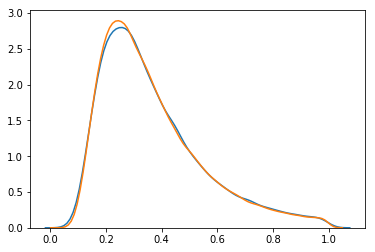

In [586]:
sns.kdeplot(np.power(catboost_pred_mean[pos],1/3))
sns.kdeplot(np.power(catboost_pred_mean[neg],1/3))

In [589]:
roc_auc_score(y_valid, np.power(y_pred_valid, 5))

0.8962900409016619

In [579]:
lgbm_pred_mean

array([0.07447161, 0.22933497, 0.21818048, ..., 0.00621476, 0.0837832 ,
       0.11567397])

In [578]:
y

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        1
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        1
         ..
199970    0
199971    0
199972    0
199973    0
199974    0
199975    0
199976    1
199977    0
199978    0
199979    0
199980    0
199981    1
199982    0
199983    0
199984    0
199985    0
199986    1
199987    0
199988    0
199989    0
199990    1
199991    0
199992    0
199993    0
199994    0
199995    0
199996    0
199997    0
199998    0
199999    0
Name: target, Length: 200000, dtype: int64

In [ ]:
X